# A1 - Proposta de Modelo de Síntese de Dado Tabular em Saúde

#### Aluno: Tiago Amorim (100.675)

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [69]:
df_agg = pd.read_csv('./data_agg.csv', parse_dates=['Date'])
# df_agg.head()

In [70]:
columns = df_agg.columns[-7:]
columns

Index(['Age', 'Sex', 'PLAQUETAS SANGUE', 'NEUTRÓFILOS ABSOLUTO',
       'LINFÓCITOS ABSOLUTO', 'NEUTRÓFILOS %', 'LINFÓCITOS %'],
      dtype='object')

# Geração de Amostras com VAE

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

In [72]:
# Baseado em: https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/

@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.

        loss_mse (torch.Tensor): The reconstruction loss MSE component of the VAE loss.
        loss_bin (torch.Tensor): The reconstruction loss binary CE component of the VAE loss.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor

    loss_recon_mse: torch.Tensor
    loss_recon_bin: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor


In [73]:
class SigmoidFirstValue(nn.Module):
    def __init__(self):
        super(SigmoidFirstValue, self).__init__()

    def forward(self, x):
        x[:, 0] = torch.sigmoid(x[:, 0])
        return x

In [74]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
        beta (float): Weight for the KL divergence term.
        alpha (float): Weight for the MSE loss term.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim, beta=1.0, alpha=0.9, n_hidden_layers=2):
        super(VAE, self).__init__()
        assert n_hidden_layers >= 1, 'Number of hidden layers must be at least 1.'

        self.latent_dim = latent_dim
        self.beta = beta
        self.alpha = alpha

        self.encoder = nn.Sequential()
        self.encoder.add_module('input_linear',nn.Linear(input_dim, hidden_dim))
        self.encoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.encoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.encoder.add_module(f'{i+1}_act',nn.SiLU())
        self.encoder.add_module('output_linear',nn.Linear(hidden_dim, 2 * latent_dim)) # mean and variance

        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential()
        self.decoder.add_module('input_linear',nn.Linear(latent_dim, hidden_dim))
        self.decoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.decoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.decoder.add_module(f'{i+1}_act',nn.SiLU())
        self.decoder.add_module('output_linear',nn.Linear(hidden_dim, input_dim))

        self.sigmoid_first_value = SigmoidFirstValue()

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.

        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        x_recon = self.decoder(z)
        x_recon = self.sigmoid_first_value(x_recon)
        return x_recon

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon_mse=None,
                loss_recon_bin=None,
                loss_recon=None,
                loss_kl=None,
            )

        loss_recon_bin = F.binary_cross_entropy(recon_x[:, 0], x[:, 0], reduction='none').sum(-1).mean()
        loss_recon_mse = F.mse_loss(recon_x[:, 1:], x[:, 1:], reduction='none').sum(-1).mean()
        loss_recon = (1 - self.alpha) * loss_recon_bin + self.alpha * loss_recon_mse

        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + self.beta * loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon_mse=loss_recon_mse,
            loss_recon_bin=loss_recon_bin,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

    def samples(self, n_samples = 1):
        """
        Gets samples from the latent space.

        Args:
            n_samples (int): Number of samples to generate.

        Returns:
            torch.Tensor: Samples from the latent space.
        """
        device = next(self.parameters()).device
        z = torch.randn(n_samples, self.latent_dim, device=device)
        return self.decode(z)


## Data Tensors

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [76]:
columns = list(columns)
columns[0], columns[1] = columns[1], columns[0]

X_values = df_agg[columns].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_values)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

## Training Functions

In [77]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [78]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [79]:
def reconstruction_fig(model, data, scaler, scaled=True):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        data = data.to(device)
        output = model(data, compute_loss=False)
        recon = output.x_recon.cpu().numpy()
        data = data.cpu().numpy()

        if not scaled:
            data = scaler.inverse_transform(data)
            recon = scaler.inverse_transform(recon)

        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            recon = recon.reshape(1, -1)
        n_samples = data.shape[0]

        fig, ax = plt.subplots(n_samples, 1, figsize=(4, 2*n_samples))
        if n_samples == 1:
            ax = [ax]
        for i in range(n_samples):
            ax[i].plot(data[i], label='Original', color='blue', marker='o')
            ax[i].plot(recon[i], label='Reconstructed', color='blue', marker='o', linestyle='--')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
        ax[0].legend()
        plt.tight_layout()
        return fig

In [80]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    device = next(model.parameters()).device
    batch_size = dataloader.batch_size

    for batch_idx, data in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon Bin: {output.loss_recon_bin.item():.4f}, Recon MSE: {output.loss_recon_mse.item():.4f}, Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('Loss/Train/Recon', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon_bin.item(), global_step)
                writer.add_scalar('Loss/Train/MSE', output.loss_recon_mse.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [81]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    device = next(model.parameters()).device

    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')

    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)

        inputs = next(iter(dataloader))
        writer.add_figure('Reconstruction', reconstruction_fig(model, inputs[:5], scaler, scaled=True), global_step=cur_step)

    return test_loss, test_recon_loss, test_kl_loss


In [82]:
def get_dataloaders(batch_size, X_train, X_test):
    train_loader = torch.utils.data.DataLoader(
        X_train,
        batch_size=batch_size,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        X_test,
        batch_size=batch_size,
        shuffle=False,
    )
    return train_loader, test_loader


def build_vae(options):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VAE(
        input_dim=7,
        hidden_dim=options['hidden_dim'],
        latent_dim=options['latent_dim'],
        beta=options['beta'],
        alpha=options['alpha'],
        n_hidden_layers=options['n_hidden_layers']
        ).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=options['learning_rate'],
        weight_decay=options['weight_decay'])
    writer = SummaryWriter(f'runs/{options["study_name"]}/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
    return model, optimizer, writer


def train_vae(options, model, optimizer, writer, train_loader, test_loader):
    prev_updates = 0
    best_loss = float('inf')
    best_losses = {}

    for epoch in range(options['num_epochs']):
        print(f'Epoch {epoch+1}/{options["num_epochs"]}')
        prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
        test_loss, test_recon_loss, test_kl_loss = test(model, test_loader, prev_updates, writer=writer)
        if test_loss < best_loss:
            best_loss = test_loss
            best_losses = {
                'hparam/test_loss': test_loss,
                'hparam/recon_loss': test_recon_loss,
                'hparam/kl_loss': test_kl_loss,
            }
    writer.add_hparams(options, best_losses)
    writer.flush()
    writer.close()


def run_vae(options, X_train, X_test):
    model, optimizer, writer = build_vae(options)
    print(f"Number of parameters in the model: {count_parameters(model)}")

    train_loader, test_loader = get_dataloaders(options['batch_size'], X_train, X_test)
    train_vae(options, model, optimizer, writer, train_loader, test_loader)
    return model

## Model Training

In [90]:
options = {
    'batch_size': 128,
    'learning_rate': 1e-3,
    'weight_decay': 1e-2,
    'num_epochs': 50,
    'latent_dim': 4,
    'hidden_dim': 6,
    'n_hidden_layers': 3,
    'beta': 5.0,
    'alpha': 0.8,
    'study_name': 'vae01',
    }

model = run_vae(options, X_train, X_test)

Number of parameters in the model: 258
Epoch 1/30


  1%|▏         | 5/365 [00:00<00:07, 45.45it/s]

Step 0 (N samples: 0), Loss: 7.3357 (Recon Bin: 4.4835, Recon MSE: 1.2698, Recon: 5.7532, KL: 1.5825) Grad: 4.4883


 38%|███▊      | 139/365 [00:00<00:01, 188.82it/s]

Step 100 (N samples: 12,800), Loss: 5.4839 (Recon Bin: 4.4240, Recon MSE: 0.6270, Recon: 5.0509, KL: 0.4329) Grad: 2.6119


 61%|██████    | 223/365 [00:01<00:00, 201.38it/s]

Step 200 (N samples: 25,600), Loss: 4.5531 (Recon Bin: 4.4359, Recon MSE: 0.1158, Recon: 4.5517, KL: 0.0014) Grad: 0.5429


 89%|████████▉ | 325/365 [00:01<00:00, 194.69it/s]

Step 300 (N samples: 38,400), Loss: 4.5089 (Recon Bin: 4.4377, Recon MSE: 0.0706, Recon: 4.5083, KL: 0.0006) Grad: 0.1526


Testing: 100%|██████████| 92/92 [00:00<00:00, 397.06it/s]


====> Test set loss: 4.4625 (BCE: 4.4620, KLD: 0.0005)
Epoch 2/30


 15%|█▌        | 56/365 [00:00<00:01, 184.83it/s]

Step 400 (N samples: 51,200), Loss: 4.5157 (Recon Bin: 4.4363, Recon MSE: 0.0790, Recon: 4.5153, KL: 0.0004) Grad: 0.2358


 43%|████▎     | 156/365 [00:00<00:01, 194.46it/s]

Step 500 (N samples: 64,000), Loss: 4.4871 (Recon Bin: 4.4127, Recon MSE: 0.0740, Recon: 4.4867, KL: 0.0003) Grad: 1.2250


 70%|███████   | 257/365 [00:01<00:00, 194.42it/s]

Step 600 (N samples: 76,800), Loss: 4.5042 (Recon Bin: 4.4363, Recon MSE: 0.0677, Recon: 4.5040, KL: 0.0002) Grad: 0.6071


100%|██████████| 365/365 [00:01<00:00, 190.90it/s]


Step 700 (N samples: 89,600), Loss: 4.5073 (Recon Bin: 4.4381, Recon MSE: 0.0691, Recon: 4.5072, KL: 0.0002) Grad: 0.2516


Testing: 100%|██████████| 92/92 [00:00<00:00, 392.66it/s]


====> Test set loss: 4.4633 (BCE: 4.4631, KLD: 0.0002)
Epoch 3/30


 27%|██▋       | 98/365 [00:00<00:01, 193.46it/s]

Step 800 (N samples: 102,400), Loss: 4.5068 (Recon Bin: 4.4361, Recon MSE: 0.0706, Recon: 4.5067, KL: 0.0001) Grad: 0.0905


 54%|█████▍    | 197/365 [00:01<00:00, 189.76it/s]

Step 900 (N samples: 115,200), Loss: 4.4995 (Recon Bin: 4.4337, Recon MSE: 0.0658, Recon: 4.4994, KL: 0.0001) Grad: 0.2669


 81%|████████  | 296/365 [00:01<00:00, 183.88it/s]

Step 1,000 (N samples: 128,000), Loss: 4.5154 (Recon Bin: 4.4380, Recon MSE: 0.0773, Recon: 4.5153, KL: 0.0001) Grad: 0.4293


Testing: 100%|██████████| 92/92 [00:00<00:00, 397.36it/s]


====> Test set loss: 4.4624 (BCE: 4.4623, KLD: 0.0001)
Epoch 4/30


  5%|▍         | 17/365 [00:00<00:02, 168.13it/s]

Step 1,100 (N samples: 140,800), Loss: 4.4990 (Recon Bin: 4.4371, Recon MSE: 0.0619, Recon: 4.4990, KL: 0.0001) Grad: 0.1709


 38%|███▊      | 139/365 [00:00<00:01, 190.80it/s]

Step 1,200 (N samples: 153,600), Loss: 4.5124 (Recon Bin: 4.4347, Recon MSE: 0.0777, Recon: 4.5124, KL: 0.0000) Grad: 0.1027


 66%|██████▌   | 240/365 [00:01<00:00, 198.65it/s]

Step 1,300 (N samples: 166,400), Loss: 4.5459 (Recon Bin: 4.4452, Recon MSE: 0.1007, Recon: 4.5459, KL: 0.0001) Grad: 0.4746


 89%|████████▉ | 325/365 [00:01<00:00, 201.61it/s]

Step 1,400 (N samples: 179,200), Loss: 4.5206 (Recon Bin: 4.4395, Recon MSE: 0.0811, Recon: 4.5206, KL: 0.0001) Grad: 0.3010


Testing: 100%|██████████| 92/92 [00:00<00:00, 410.65it/s]


====> Test set loss: 4.4627 (BCE: 4.4626, KLD: 0.0000)
Epoch 5/30


 22%|██▏       | 80/365 [00:00<00:01, 194.41it/s]

Step 1,500 (N samples: 192,000), Loss: 4.5127 (Recon Bin: 4.4470, Recon MSE: 0.0657, Recon: 4.5127, KL: 0.0000) Grad: 0.6737


 44%|████▍     | 161/365 [00:00<00:01, 191.00it/s]

Step 1,600 (N samples: 204,800), Loss: 4.5044 (Recon Bin: 4.4358, Recon MSE: 0.0686, Recon: 4.5044, KL: 0.0000) Grad: 0.1865


 72%|███████▏  | 262/365 [00:01<00:00, 194.70it/s]

Step 1,700 (N samples: 217,600), Loss: 4.5042 (Recon Bin: 4.4319, Recon MSE: 0.0722, Recon: 4.5041, KL: 0.0000) Grad: 0.2298


100%|██████████| 365/365 [00:01<00:00, 193.35it/s]


Step 1,800 (N samples: 230,400), Loss: 4.5032 (Recon Bin: 4.4353, Recon MSE: 0.0679, Recon: 4.5032, KL: 0.0000) Grad: 0.1130


Testing: 100%|██████████| 92/92 [00:00<00:00, 430.41it/s]


====> Test set loss: 4.4623 (BCE: 4.4622, KLD: 0.0000)
Epoch 6/30


 27%|██▋       | 99/365 [00:00<00:01, 198.90it/s]

Step 1,900 (N samples: 243,200), Loss: 4.5126 (Recon Bin: 4.4314, Recon MSE: 0.0811, Recon: 4.5125, KL: 0.0000) Grad: 0.2074


 55%|█████▍    | 200/365 [00:01<00:00, 197.56it/s]

Step 2,000 (N samples: 256,000), Loss: 4.5071 (Recon Bin: 4.4355, Recon MSE: 0.0716, Recon: 4.5071, KL: 0.0000) Grad: 0.1326


 83%|████████▎ | 304/365 [00:01<00:00, 189.96it/s]

Step 2,100 (N samples: 268,800), Loss: 4.5131 (Recon Bin: 4.4321, Recon MSE: 0.0810, Recon: 4.5131, KL: 0.0000) Grad: 0.5827


Testing: 100%|██████████| 92/92 [00:00<00:00, 384.30it/s]


====> Test set loss: 4.4620 (BCE: 4.4619, KLD: 0.0000)
Epoch 7/30


  5%|▍         | 17/365 [00:00<00:02, 167.27it/s]

Step 2,200 (N samples: 281,600), Loss: 4.4924 (Recon Bin: 4.4311, Recon MSE: 0.0613, Recon: 4.4924, KL: 0.0000) Grad: 0.3730


 38%|███▊      | 140/365 [00:00<00:01, 200.38it/s]

Step 2,300 (N samples: 294,400), Loss: 4.4949 (Recon Bin: 4.4199, Recon MSE: 0.0749, Recon: 4.4949, KL: 0.0000) Grad: 0.5945


 67%|██████▋   | 243/365 [00:01<00:00, 197.45it/s]

Step 2,400 (N samples: 307,200), Loss: 4.4983 (Recon Bin: 4.4361, Recon MSE: 0.0622, Recon: 4.4983, KL: 0.0000) Grad: 0.1730


 95%|█████████▍| 345/365 [00:01<00:00, 196.80it/s]

Step 2,500 (N samples: 320,000), Loss: 4.5186 (Recon Bin: 4.4372, Recon MSE: 0.0814, Recon: 4.5186, KL: 0.0000) Grad: 0.1191


Testing: 100%|██████████| 92/92 [00:00<00:00, 434.95it/s]


====> Test set loss: 4.4631 (BCE: 4.4630, KLD: 0.0000)
Epoch 8/30


 21%|██        | 75/365 [00:00<00:01, 186.91it/s]

Step 2,600 (N samples: 332,800), Loss: 4.5272 (Recon Bin: 4.4443, Recon MSE: 0.0829, Recon: 4.5272, KL: 0.0000) Grad: 0.8946


 48%|████▊     | 175/365 [00:00<00:00, 190.41it/s]

Step 2,700 (N samples: 345,600), Loss: 4.5169 (Recon Bin: 4.4361, Recon MSE: 0.0808, Recon: 4.5169, KL: 0.0000) Grad: 0.5411


 76%|███████▌  | 276/365 [00:01<00:00, 193.23it/s]

Step 2,800 (N samples: 358,400), Loss: 4.5093 (Recon Bin: 4.4296, Recon MSE: 0.0797, Recon: 4.5093, KL: 0.0000) Grad: 0.7048


100%|██████████| 365/365 [00:01<00:00, 191.30it/s]


Step 2,900 (N samples: 371,200), Loss: 4.5115 (Recon Bin: 4.4368, Recon MSE: 0.0747, Recon: 4.5115, KL: 0.0000) Grad: 0.0457


Testing: 100%|██████████| 92/92 [00:00<00:00, 403.67it/s]


====> Test set loss: 4.4621 (BCE: 4.4621, KLD: 0.0000)
Epoch 9/30


 28%|██▊       | 101/365 [00:00<00:01, 201.09it/s]

Step 3,000 (N samples: 384,000), Loss: 4.5031 (Recon Bin: 4.4351, Recon MSE: 0.0680, Recon: 4.5031, KL: 0.0000) Grad: 0.0726


 56%|█████▌    | 204/365 [00:01<00:00, 198.42it/s]

Step 3,100 (N samples: 396,800), Loss: 4.4975 (Recon Bin: 4.4284, Recon MSE: 0.0691, Recon: 4.4975, KL: 0.0000) Grad: 0.4980


 84%|████████▎ | 305/365 [00:01<00:00, 195.40it/s]

Step 3,200 (N samples: 409,600), Loss: 4.5157 (Recon Bin: 4.4395, Recon MSE: 0.0762, Recon: 4.5156, KL: 0.0000) Grad: 0.4249


Testing: 100%|██████████| 92/92 [00:00<00:00, 400.52it/s]


====> Test set loss: 4.4632 (BCE: 4.4632, KLD: 0.0000)
Epoch 10/30


  4%|▍         | 15/365 [00:00<00:02, 146.28it/s]

Step 3,300 (N samples: 422,400), Loss: 4.5209 (Recon Bin: 4.4367, Recon MSE: 0.0842, Recon: 4.5208, KL: 0.0000) Grad: 0.1465


 42%|████▏     | 152/365 [00:00<00:01, 189.97it/s]

Step 3,400 (N samples: 435,200), Loss: 4.5089 (Recon Bin: 4.4328, Recon MSE: 0.0762, Recon: 4.5089, KL: 0.0000) Grad: 0.9182


 70%|██████▉   | 255/365 [00:01<00:00, 199.21it/s]

Step 3,500 (N samples: 448,000), Loss: 4.5205 (Recon Bin: 4.4417, Recon MSE: 0.0788, Recon: 4.5205, KL: 0.0000) Grad: 0.4887


 92%|█████████▏| 337/365 [00:01<00:00, 191.96it/s]

Step 3,600 (N samples: 460,800), Loss: 4.5066 (Recon Bin: 4.4333, Recon MSE: 0.0732, Recon: 4.5066, KL: 0.0000) Grad: 0.1630


Testing: 100%|██████████| 92/92 [00:00<00:00, 425.51it/s]


====> Test set loss: 4.4617 (BCE: 4.4617, KLD: 0.0000)
Epoch 11/30


 22%|██▏       | 79/365 [00:00<00:01, 186.97it/s]

Step 3,700 (N samples: 473,600), Loss: 4.5162 (Recon Bin: 4.4372, Recon MSE: 0.0790, Recon: 4.5162, KL: 0.0000) Grad: 0.1185


 49%|████▉     | 179/365 [00:00<00:00, 191.88it/s]

Step 3,800 (N samples: 486,400), Loss: 4.5151 (Recon Bin: 4.4349, Recon MSE: 0.0801, Recon: 4.5151, KL: 0.0000) Grad: 0.0361


 76%|███████▌  | 278/365 [00:01<00:00, 187.91it/s]

Step 3,900 (N samples: 499,200), Loss: 4.5212 (Recon Bin: 4.4369, Recon MSE: 0.0843, Recon: 4.5212, KL: 0.0000) Grad: 0.0940


100%|██████████| 365/365 [00:01<00:00, 189.26it/s]


Step 4,000 (N samples: 512,000), Loss: 4.5026 (Recon Bin: 4.4373, Recon MSE: 0.0652, Recon: 4.5026, KL: 0.0000) Grad: 0.1485


Testing: 100%|██████████| 92/92 [00:00<00:00, 421.49it/s]


====> Test set loss: 4.4621 (BCE: 4.4621, KLD: 0.0000)
Epoch 12/30


 33%|███▎      | 119/365 [00:00<00:01, 190.20it/s]

Step 4,100 (N samples: 524,800), Loss: 4.5080 (Recon Bin: 4.4366, Recon MSE: 0.0714, Recon: 4.5080, KL: 0.0000) Grad: 0.1771


 60%|██████    | 219/365 [00:01<00:00, 196.79it/s]

Step 4,200 (N samples: 537,600), Loss: 4.4933 (Recon Bin: 4.4294, Recon MSE: 0.0638, Recon: 4.4933, KL: 0.0000) Grad: 0.2718


 88%|████████▊ | 320/365 [00:01<00:00, 195.72it/s]

Step 4,300 (N samples: 550,400), Loss: 4.5089 (Recon Bin: 4.4341, Recon MSE: 0.0749, Recon: 4.5089, KL: 0.0000) Grad: 0.4605


Testing: 100%|██████████| 92/92 [00:00<00:00, 419.46it/s]


====> Test set loss: 4.4628 (BCE: 4.4628, KLD: 0.0000)
Epoch 13/30


 16%|█▌        | 58/365 [00:00<00:01, 194.94it/s]

Step 4,400 (N samples: 563,200), Loss: 4.4984 (Recon Bin: 4.4328, Recon MSE: 0.0656, Recon: 4.4984, KL: 0.0000) Grad: 0.5060


 39%|███▊      | 141/365 [00:00<00:01, 199.99it/s]

Step 4,500 (N samples: 576,000), Loss: 4.5192 (Recon Bin: 4.4418, Recon MSE: 0.0775, Recon: 4.5192, KL: 0.0000) Grad: 0.3120


 67%|██████▋   | 245/365 [00:01<00:00, 199.53it/s]

Step 4,600 (N samples: 588,800), Loss: 4.5174 (Recon Bin: 4.4384, Recon MSE: 0.0791, Recon: 4.5174, KL: 0.0000) Grad: 0.5352


 96%|█████████▌| 349/365 [00:01<00:00, 199.38it/s]

Step 4,700 (N samples: 601,600), Loss: 4.5210 (Recon Bin: 4.4373, Recon MSE: 0.0837, Recon: 4.5210, KL: 0.0000) Grad: 0.2169


Testing: 100%|██████████| 92/92 [00:00<00:00, 396.62it/s]


====> Test set loss: 4.4629 (BCE: 4.4629, KLD: 0.0000)
Epoch 14/30


 22%|██▏       | 79/365 [00:00<00:01, 195.20it/s]

Step 4,800 (N samples: 614,400), Loss: 4.5184 (Recon Bin: 4.4404, Recon MSE: 0.0781, Recon: 4.5184, KL: 0.0000) Grad: 0.5999


 49%|████▉     | 179/365 [00:00<00:00, 193.00it/s]

Step 4,900 (N samples: 627,200), Loss: 4.5252 (Recon Bin: 4.4365, Recon MSE: 0.0887, Recon: 4.5252, KL: 0.0000) Grad: 0.0711


 76%|███████▋  | 279/365 [00:01<00:00, 194.38it/s]

Step 5,000 (N samples: 640,000), Loss: 4.5125 (Recon Bin: 4.4400, Recon MSE: 0.0725, Recon: 4.5125, KL: 0.0000) Grad: 0.3055


100%|██████████| 365/365 [00:01<00:00, 193.33it/s]


Step 5,100 (N samples: 652,800), Loss: 4.5060 (Recon Bin: 4.4320, Recon MSE: 0.0740, Recon: 4.5060, KL: 0.0000) Grad: 0.2989


Testing: 100%|██████████| 92/92 [00:00<00:00, 384.76it/s]


====> Test set loss: 4.4622 (BCE: 4.4622, KLD: 0.0000)
Epoch 15/30


 31%|███       | 114/365 [00:00<00:01, 192.47it/s]

Step 5,200 (N samples: 665,600), Loss: 4.5118 (Recon Bin: 4.4431, Recon MSE: 0.0687, Recon: 4.5118, KL: 0.0000) Grad: 0.3349


 59%|█████▉    | 215/365 [00:01<00:00, 187.73it/s]

Step 5,300 (N samples: 678,400), Loss: 4.5140 (Recon Bin: 4.4347, Recon MSE: 0.0793, Recon: 4.5140, KL: 0.0000) Grad: 0.3801


 86%|████████▋ | 315/365 [00:01<00:00, 193.99it/s]

Step 5,400 (N samples: 691,200), Loss: 4.5066 (Recon Bin: 4.4326, Recon MSE: 0.0740, Recon: 4.5066, KL: 0.0000) Grad: 0.2984


Testing: 100%|██████████| 92/92 [00:00<00:00, 406.86it/s]


====> Test set loss: 4.4623 (BCE: 4.4623, KLD: 0.0000)
Epoch 16/30


 16%|█▌        | 57/365 [00:00<00:01, 186.64it/s]

Step 5,500 (N samples: 704,000), Loss: 4.5071 (Recon Bin: 4.4343, Recon MSE: 0.0727, Recon: 4.5071, KL: 0.0000) Grad: 0.0912


 42%|████▏     | 154/365 [00:00<00:01, 185.39it/s]

Step 5,600 (N samples: 716,800), Loss: 4.5096 (Recon Bin: 4.4336, Recon MSE: 0.0760, Recon: 4.5096, KL: 0.0000) Grad: 0.6390


 70%|███████   | 257/365 [00:01<00:00, 196.77it/s]

Step 5,700 (N samples: 729,600), Loss: 4.5013 (Recon Bin: 4.4248, Recon MSE: 0.0765, Recon: 4.5013, KL: 0.0000) Grad: 0.5295


 99%|█████████▊| 360/365 [00:01<00:00, 198.85it/s]

Step 5,800 (N samples: 742,400), Loss: 4.5078 (Recon Bin: 4.4299, Recon MSE: 0.0778, Recon: 4.5078, KL: 0.0000) Grad: 0.8870


Testing: 100%|██████████| 92/92 [00:00<00:00, 426.05it/s]


====> Test set loss: 4.4632 (BCE: 4.4632, KLD: 0.0000)
Epoch 17/30


 25%|██▌       | 93/365 [00:00<00:01, 183.41it/s]

Step 5,900 (N samples: 755,200), Loss: 4.5103 (Recon Bin: 4.4287, Recon MSE: 0.0816, Recon: 4.5103, KL: 0.0000) Grad: 0.8175


 53%|█████▎    | 193/365 [00:01<00:00, 188.25it/s]

Step 6,000 (N samples: 768,000), Loss: 4.4977 (Recon Bin: 4.4161, Recon MSE: 0.0816, Recon: 4.4977, KL: 0.0000) Grad: 0.9048


 80%|████████  | 293/365 [00:01<00:00, 192.18it/s]

Step 6,100 (N samples: 780,800), Loss: 4.4914 (Recon Bin: 4.4280, Recon MSE: 0.0634, Recon: 4.4914, KL: 0.0000) Grad: 0.4760


100%|██████████| 365/365 [00:01<00:00, 187.45it/s]


Step 6,200 (N samples: 793,600), Loss: 4.5142 (Recon Bin: 4.4462, Recon MSE: 0.0680, Recon: 4.5142, KL: 0.0000) Grad: 0.7481


Testing: 100%|██████████| 92/92 [00:00<00:00, 428.88it/s]


====> Test set loss: 4.4623 (BCE: 4.4623, KLD: 0.0000)
Epoch 18/30


 33%|███▎      | 121/365 [00:00<00:01, 195.95it/s]

Step 6,300 (N samples: 806,400), Loss: 4.5145 (Recon Bin: 4.4387, Recon MSE: 0.0758, Recon: 4.5145, KL: 0.0000) Grad: 0.4609


 61%|██████    | 222/365 [00:01<00:00, 193.25it/s]

Step 6,400 (N samples: 819,200), Loss: 4.5097 (Recon Bin: 4.4315, Recon MSE: 0.0782, Recon: 4.5097, KL: 0.0000) Grad: 0.2862


 89%|████████▉ | 324/365 [00:01<00:00, 190.35it/s]

Step 6,500 (N samples: 832,000), Loss: 4.5071 (Recon Bin: 4.4358, Recon MSE: 0.0713, Recon: 4.5071, KL: 0.0000) Grad: 0.3790


Testing: 100%|██████████| 92/92 [00:00<00:00, 400.15it/s]


====> Test set loss: 4.4621 (BCE: 4.4621, KLD: 0.0000)
Epoch 19/30


 15%|█▌        | 56/365 [00:00<00:01, 185.10it/s]

Step 6,600 (N samples: 844,800), Loss: 4.5304 (Recon Bin: 4.4401, Recon MSE: 0.0904, Recon: 4.5304, KL: 0.0000) Grad: 0.3534


 42%|████▏     | 155/365 [00:00<00:01, 187.33it/s]

Step 6,700 (N samples: 857,600), Loss: 4.5154 (Recon Bin: 4.4383, Recon MSE: 0.0771, Recon: 4.5154, KL: 0.0000) Grad: 0.3596


 70%|██████▉   | 254/365 [00:01<00:00, 191.97it/s]

Step 6,800 (N samples: 870,400), Loss: 4.5146 (Recon Bin: 4.4361, Recon MSE: 0.0785, Recon: 4.5146, KL: 0.0000) Grad: 0.1070


100%|██████████| 365/365 [00:01<00:00, 190.52it/s]


Step 6,900 (N samples: 883,200), Loss: 4.5095 (Recon Bin: 4.4368, Recon MSE: 0.0727, Recon: 4.5095, KL: 0.0000) Grad: 0.0938


Testing: 100%|██████████| 92/92 [00:00<00:00, 412.64it/s]


====> Test set loss: 4.4621 (BCE: 4.4621, KLD: 0.0000)
Epoch 20/30


 28%|██▊       | 102/365 [00:00<00:01, 196.34it/s]

Step 7,000 (N samples: 896,000), Loss: 4.5099 (Recon Bin: 4.4377, Recon MSE: 0.0723, Recon: 4.5099, KL: 0.0000) Grad: 0.1372


 55%|█████▌    | 202/365 [00:01<00:00, 194.82it/s]

Step 7,100 (N samples: 908,800), Loss: 4.5043 (Recon Bin: 4.4303, Recon MSE: 0.0739, Recon: 4.5043, KL: 0.0000) Grad: 0.1971


 83%|████████▎ | 302/365 [00:01<00:00, 186.69it/s]

Step 7,200 (N samples: 921,600), Loss: 4.4928 (Recon Bin: 4.4316, Recon MSE: 0.0612, Recon: 4.4928, KL: 0.0000) Grad: 0.4907


Testing: 100%|██████████| 92/92 [00:00<00:00, 405.58it/s]


====> Test set loss: 4.4623 (BCE: 4.4623, KLD: 0.0000)
Epoch 21/30


  3%|▎         | 10/365 [00:00<00:03, 98.77it/s]

Step 7,300 (N samples: 934,400), Loss: 4.5246 (Recon Bin: 4.4410, Recon MSE: 0.0837, Recon: 4.5246, KL: 0.0000) Grad: 0.4061


 33%|███▎      | 121/365 [00:00<00:01, 185.46it/s]

Step 7,400 (N samples: 947,200), Loss: 4.5271 (Recon Bin: 4.4444, Recon MSE: 0.0827, Recon: 4.5271, KL: 0.0000) Grad: 0.5472


 61%|██████    | 223/365 [00:01<00:00, 197.45it/s]

Step 7,500 (N samples: 960,000), Loss: 4.5185 (Recon Bin: 4.4346, Recon MSE: 0.0840, Recon: 4.5185, KL: 0.0000) Grad: 0.1329


 89%|████████▉ | 325/365 [00:01<00:00, 197.32it/s]

Step 7,600 (N samples: 972,800), Loss: 4.5033 (Recon Bin: 4.4357, Recon MSE: 0.0677, Recon: 4.5033, KL: 0.0000) Grad: 0.0931


Testing: 100%|██████████| 92/92 [00:00<00:00, 422.39it/s]


====> Test set loss: 4.4618 (BCE: 4.4618, KLD: 0.0000)
Epoch 22/30


 16%|█▌        | 59/365 [00:00<00:01, 195.11it/s]

Step 7,700 (N samples: 985,600), Loss: 4.4955 (Recon Bin: 4.4219, Recon MSE: 0.0736, Recon: 4.4955, KL: 0.0000) Grad: 0.9104


 44%|████▍     | 160/365 [00:00<00:01, 194.96it/s]

Step 7,800 (N samples: 998,400), Loss: 4.5293 (Recon Bin: 4.4357, Recon MSE: 0.0936, Recon: 4.5293, KL: 0.0000) Grad: 0.0847


 72%|███████▏  | 263/365 [00:01<00:00, 200.69it/s]

Step 7,900 (N samples: 1,011,200), Loss: 4.4986 (Recon Bin: 4.4312, Recon MSE: 0.0673, Recon: 4.4986, KL: 0.0000) Grad: 0.3678


100%|██████████| 365/365 [00:01<00:00, 192.60it/s]


Step 8,000 (N samples: 1,024,000), Loss: 4.5150 (Recon Bin: 4.4400, Recon MSE: 0.0750, Recon: 4.5150, KL: 0.0000) Grad: 0.2353


Testing: 100%|██████████| 92/92 [00:00<00:00, 410.87it/s]


====> Test set loss: 4.4627 (BCE: 4.4627, KLD: 0.0000)
Epoch 23/30


 27%|██▋       | 99/365 [00:00<00:01, 196.54it/s]

Step 8,100 (N samples: 1,036,800), Loss: 4.5055 (Recon Bin: 4.4350, Recon MSE: 0.0705, Recon: 4.5055, KL: 0.0000) Grad: 0.2466


 56%|█████▌    | 203/365 [00:01<00:00, 198.65it/s]

Step 8,200 (N samples: 1,049,600), Loss: 4.5146 (Recon Bin: 4.4347, Recon MSE: 0.0800, Recon: 4.5146, KL: 0.0000) Grad: 0.1013


 84%|████████▎ | 305/365 [00:01<00:00, 197.80it/s]

Step 8,300 (N samples: 1,062,400), Loss: 4.5162 (Recon Bin: 4.4408, Recon MSE: 0.0755, Recon: 4.5162, KL: 0.0000) Grad: 0.3018


Testing: 100%|██████████| 92/92 [00:00<00:00, 427.29it/s]


====> Test set loss: 4.4626 (BCE: 4.4626, KLD: 0.0000)
Epoch 24/30


  5%|▍         | 17/365 [00:00<00:02, 164.56it/s]

Step 8,400 (N samples: 1,075,200), Loss: 4.5129 (Recon Bin: 4.4369, Recon MSE: 0.0760, Recon: 4.5129, KL: 0.0000) Grad: 0.1370


 37%|███▋      | 136/365 [00:00<00:01, 193.68it/s]

Step 8,500 (N samples: 1,088,000), Loss: 4.5253 (Recon Bin: 4.4360, Recon MSE: 0.0893, Recon: 4.5253, KL: 0.0000) Grad: 0.0947


 65%|██████▍   | 236/365 [00:01<00:00, 191.43it/s]

Step 8,600 (N samples: 1,100,800), Loss: 4.5158 (Recon Bin: 4.4374, Recon MSE: 0.0785, Recon: 4.5158, KL: 0.0000) Grad: 0.1230


 92%|█████████▏| 335/365 [00:01<00:00, 189.40it/s]

Step 8,700 (N samples: 1,113,600), Loss: 4.5155 (Recon Bin: 4.4291, Recon MSE: 0.0864, Recon: 4.5155, KL: 0.0000) Grad: 0.4629


Testing: 100%|██████████| 92/92 [00:00<00:00, 411.17it/s]


====> Test set loss: 4.4629 (BCE: 4.4629, KLD: 0.0000)
Epoch 25/30


 16%|█▌        | 57/365 [00:00<00:01, 183.08it/s]

Step 8,800 (N samples: 1,126,400), Loss: 4.5107 (Recon Bin: 4.4375, Recon MSE: 0.0732, Recon: 4.5107, KL: 0.0000) Grad: 0.2078


 48%|████▊     | 176/365 [00:00<00:00, 190.19it/s]

Step 8,900 (N samples: 1,139,200), Loss: 4.5086 (Recon Bin: 4.4366, Recon MSE: 0.0720, Recon: 4.5086, KL: 0.0000) Grad: 0.0666


 76%|███████▋  | 279/365 [00:01<00:00, 197.37it/s]

Step 9,000 (N samples: 1,152,000), Loss: 4.5102 (Recon Bin: 4.4359, Recon MSE: 0.0742, Recon: 4.5101, KL: 0.0000) Grad: 0.0696


100%|██████████| 365/365 [00:01<00:00, 188.92it/s]


Step 9,100 (N samples: 1,164,800), Loss: 4.5118 (Recon Bin: 4.4350, Recon MSE: 0.0768, Recon: 4.5118, KL: 0.0000) Grad: 0.0789


Testing: 100%|██████████| 92/92 [00:00<00:00, 397.90it/s]


====> Test set loss: 4.4624 (BCE: 4.4624, KLD: 0.0000)
Epoch 26/30


 28%|██▊       | 101/365 [00:00<00:01, 192.02it/s]

Step 9,200 (N samples: 1,177,600), Loss: 4.5308 (Recon Bin: 4.4332, Recon MSE: 0.0976, Recon: 4.5308, KL: 0.0000) Grad: 0.3539


 55%|█████▌    | 202/365 [00:01<00:00, 193.04it/s]

Step 9,300 (N samples: 1,190,400), Loss: 4.5325 (Recon Bin: 4.4326, Recon MSE: 0.0999, Recon: 4.5325, KL: 0.0000) Grad: 0.1622


 82%|████████▏ | 300/365 [00:01<00:00, 189.23it/s]

Step 9,400 (N samples: 1,203,200), Loss: 4.5204 (Recon Bin: 4.4413, Recon MSE: 0.0792, Recon: 4.5204, KL: 0.0000) Grad: 0.3561


Testing: 100%|██████████| 92/92 [00:00<00:00, 447.87it/s]


====> Test set loss: 4.4627 (BCE: 4.4627, KLD: 0.0000)
Epoch 27/30


  5%|▍         | 17/365 [00:00<00:02, 164.69it/s]

Step 9,500 (N samples: 1,216,000), Loss: 4.5279 (Recon Bin: 4.4384, Recon MSE: 0.0895, Recon: 4.5279, KL: 0.0000) Grad: 0.6900


 37%|███▋      | 135/365 [00:00<00:01, 192.08it/s]

Step 9,600 (N samples: 1,228,800), Loss: 4.5130 (Recon Bin: 4.4414, Recon MSE: 0.0716, Recon: 4.5130, KL: 0.0000) Grad: 0.2984


 65%|██████▌   | 238/365 [00:01<00:00, 199.39it/s]

Step 9,700 (N samples: 1,241,600), Loss: 4.5101 (Recon Bin: 4.4327, Recon MSE: 0.0774, Recon: 4.5101, KL: 0.0000) Grad: 0.2860


 93%|█████████▎| 339/365 [00:01<00:00, 196.43it/s]

Step 9,800 (N samples: 1,254,400), Loss: 4.5147 (Recon Bin: 4.4320, Recon MSE: 0.0827, Recon: 4.5147, KL: 0.0000) Grad: 0.1609


Testing: 100%|██████████| 92/92 [00:00<00:00, 424.96it/s]


====> Test set loss: 4.4617 (BCE: 4.4617, KLD: 0.0000)
Epoch 28/30


 21%|██        | 76/365 [00:00<00:01, 189.69it/s]

Step 9,900 (N samples: 1,267,200), Loss: 4.4996 (Recon Bin: 4.4276, Recon MSE: 0.0720, Recon: 4.4996, KL: 0.0000) Grad: 0.3112


 48%|████▊     | 177/365 [00:00<00:00, 194.01it/s]

Step 10,000 (N samples: 1,280,000), Loss: 4.5167 (Recon Bin: 4.4327, Recon MSE: 0.0840, Recon: 4.5167, KL: 0.0000) Grad: 0.1591


 76%|███████▌  | 277/365 [00:01<00:00, 192.47it/s]

Step 10,100 (N samples: 1,292,800), Loss: 4.5330 (Recon Bin: 4.4391, Recon MSE: 0.0939, Recon: 4.5330, KL: 0.0000) Grad: 0.6260


100%|██████████| 365/365 [00:01<00:00, 190.86it/s]


Step 10,200 (N samples: 1,305,600), Loss: 4.5129 (Recon Bin: 4.4385, Recon MSE: 0.0744, Recon: 4.5129, KL: 0.0000) Grad: 0.3262


Testing: 100%|██████████| 92/92 [00:00<00:00, 437.43it/s]


====> Test set loss: 4.4630 (BCE: 4.4630, KLD: 0.0000)
Epoch 29/30


 33%|███▎      | 119/365 [00:00<00:01, 192.42it/s]

Step 10,300 (N samples: 1,318,400), Loss: 4.5229 (Recon Bin: 4.4426, Recon MSE: 0.0803, Recon: 4.5229, KL: 0.0000) Grad: 0.4191


 60%|██████    | 219/365 [00:01<00:00, 191.60it/s]

Step 10,400 (N samples: 1,331,200), Loss: 4.5079 (Recon Bin: 4.4356, Recon MSE: 0.0722, Recon: 4.5079, KL: 0.0000) Grad: 0.1189


 87%|████████▋ | 318/365 [00:01<00:00, 189.14it/s]

Step 10,500 (N samples: 1,344,000), Loss: 4.5184 (Recon Bin: 4.4315, Recon MSE: 0.0869, Recon: 4.5184, KL: 0.0000) Grad: 0.2696


Testing: 100%|██████████| 92/92 [00:00<00:00, 410.90it/s]


====> Test set loss: 4.4631 (BCE: 4.4631, KLD: 0.0000)
Epoch 30/30


  5%|▍         | 17/365 [00:00<00:02, 169.41it/s]

Step 10,600 (N samples: 1,356,800), Loss: 4.5104 (Recon Bin: 4.4357, Recon MSE: 0.0747, Recon: 4.5104, KL: 0.0000) Grad: 0.1987


 42%|████▏     | 154/365 [00:00<00:01, 195.48it/s]

Step 10,700 (N samples: 1,369,600), Loss: 4.5142 (Recon Bin: 4.4366, Recon MSE: 0.0775, Recon: 4.5142, KL: 0.0000) Grad: 0.0791


 65%|██████▍   | 237/365 [00:01<00:00, 198.91it/s]

Step 10,800 (N samples: 1,382,400), Loss: 4.5090 (Recon Bin: 4.4359, Recon MSE: 0.0731, Recon: 4.5090, KL: 0.0000) Grad: 0.2493


 93%|█████████▎| 341/365 [00:01<00:00, 199.49it/s]

Step 10,900 (N samples: 1,395,200), Loss: 4.5143 (Recon Bin: 4.4397, Recon MSE: 0.0746, Recon: 4.5143, KL: 0.0000) Grad: 0.3341


Testing: 100%|██████████| 92/92 [00:00<00:00, 413.90it/s]


====> Test set loss: 4.4627 (BCE: 4.4627, KLD: 0.0000)


## Sampling

In [91]:
model.eval()
samples = model.samples(1000).to('cpu').detach().numpy()
samples_original_scale = scaler.inverse_transform(samples)

# samples_original_scale[samples_original_scale < 0] = 0
# samples_original_scale[:,1] = samples_original_scale[:,1].round(0)
df_samples = pd.DataFrame(samples_original_scale, columns=columns)

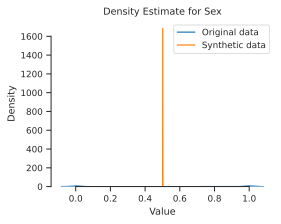

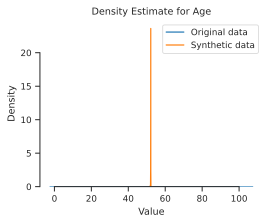

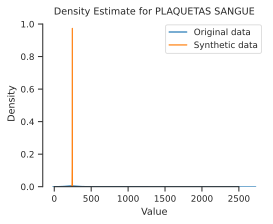

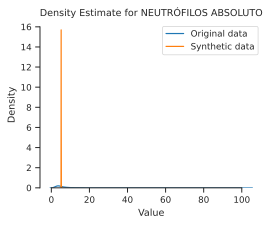

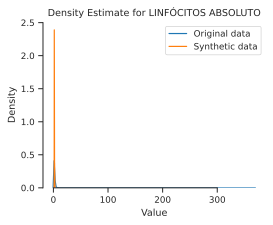

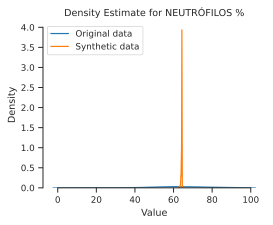

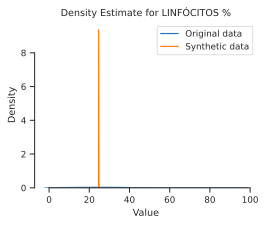

In [92]:
for t in columns:
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.kdeplot(df_agg[t], label='Original data', ax=ax, bw_adjust=0.5)
    sns.kdeplot(df_samples[t], label='Synthetic data', ax=ax, bw_adjust=0.5)
    ax.set_title(f"Density Estimate for {t}")
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    sns.despine(trim=True)
    ax.legend();